<a href="https://colab.research.google.com/github/roshantac/ERA/blob/main/Session08/Cifar_using_custom_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/roshantac/ERA.git
!cp ERA/Session09/*.py .

Cloning into 'ERA'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 76 (delta 25), reused 14 (delta 4), pack-reused 0
Unpacking objects: 100% (76/76), 416.48 KiB | 3.47 MiB/s, done.


In [7]:
!nvidia-smi

Wed Jul 12 14:54:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
%matplotlib inline
!pip install torchsummary

In [9]:
import torch
import torchvision
import torchvision.transforms as transforms

#Import DataSet


In [11]:
from dataset import *
trainloader, testloader, testloader2, classes = getData()

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Model with batch normalisation

In [29]:
import torch.nn as nn
import torch.nn.functional as F
from base_functions import *
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.C1 = Conv2d_BN(3,24,dropout=0.1, padding=1)     # 32    C1
        self.C2 = Conv2d_BN(24,32,dropout=0.1, padding=1)    # 32 #. C2
        self.c_3= Conv1x1(32,20)
        self.P1 = Maxpooling(2)
        self.C3 = Conv2d_BN(20,32,dropout=0.1, padding=1)  #16 #. C3
        self.C4 = Conv2d_BN(32,24,dropout=0.1, padding=1)   # 16 #  C4
        self.C5 = Conv2d_BN(24,40,dropout=0.1, padding=1)#16#. C5
        self.c_6= Conv1x1(40,32)                           #  C6
        self.P2 = Maxpooling(2)
        self.C7 = Conv2d_BN(32,20, dropout=0.1, padding=1) # 8.#. C7
        self.C8 = Conv2d_BN(20,32, dropout=0.1, padding=1) # 8  #  C8
        self.C9 = Conv2d_BN(32,20, padding=1) #. C9
        self.gap= gap(8)
        self.FC = Conv1x1(20,10)


    def forward(self,x):
      #32
      x = self.C1(x)
      x = self.C2(x)
      x = self.c_3(x)
      x = self.P1(x)
      #16
      s = self.C3(x)
      x = self.C4(s)
      x = self.C5(x)
      x = self.c_6(x) + s
      s2 = self.P2(x)
      #8
      s = self.C7(s2)
      x = self.C8(s) + s2
      x = self.C9(x) + s
      #gap
      x = self.gap(x)
      x = self.FC(x)
      x=x.view(-1,10)
      return F.log_softmax(x, dim= -1)



# Model with Group Normalisation

In [37]:
import torch.nn as nn
import torch.nn.functional as F
from base_functions import *
class NetGN(nn.Module):
    def __init__(self):
        super(NetGN, self).__init__()
        self.C1 = Conv2d_GN(3,24,dropout=0.1,group=4, padding=1)     # 32    C1
        self.C2 = Conv2d_GN(24,32,dropout=0.1,group=4, padding=1)    # 32 #. C2
        self.c_3= Conv1x1(32,20)
        self.P1 = Maxpooling(2)
        self.C3 = Conv2d_GN(20,32,dropout=0.1, padding=1, group=4)  #16 #. C3
        self.C4 = Conv2d_GN(32,24,dropout=0.1, padding=1, group=4)   # 16 #  C4
        self.C5 = Conv2d_GN(24,40,dropout=0.1, padding=1, group=4)#16#. C5
        self.c_6= Conv1x1(40,32)                           #  C6
        self.P2 = Maxpooling(2)
        self.C7 = Conv2d_GN(32,20, dropout=0.1, padding=1, group=4) # 8.#. C7
        self.C8 = Conv2d_GN(20,32, dropout=0.1, padding=1, group=4) # 8  #  C8
        self.C9 = Conv2d(32,20, padding=1) #. C9
        self.gap= gap(8)
        self.FC = Conv1x1(20,10)


    def forward(self,x):
      #32
      x = self.C1(x)
      x = self.C2(x)
      x = self.c_3(x)
      x = self.P1(x)
      #16
      s = self.C3(x)
      x = self.C4(s)
      x = self.C5(x)
      x = self.c_6(x) + s
      s2 = self.P2(x)
      #8
      s = self.C7(s2)
      x = self.C8(s) + s2
      x = self.C9(x) + s
      #gap
      x = self.gap(x)
      x = self.FC(x)
      x=x.view(-1,10)
      return F.log_softmax(x, dim= -1)



#Model With Layer Normalisation

In [31]:
import torch.nn as nn
import torch.nn.functional as F
from base_functions import *
class NetLN(nn.Module):
    def __init__(self):
        super(NetLN, self).__init__()
        self.C1 = Conv2d_GN(3,24,dropout=0.1,group=1, padding=1)     # 32    C1
        self.C2 = Conv2d_GN(24,32,dropout=0.1,group=1, padding=1)    # 32 #. C2
        self.c_3= Conv1x1(32,20)
        self.P1 = Maxpooling(2)
        self.C3 = Conv2d_GN(20,32,dropout=0.1, padding=1, group=1)  #16 #. C3
        self.C4 = Conv2d_GN(32,24,dropout=0.1, padding=1, group=1)   # 16 #  C4
        self.C5 = Conv2d_GN(24,40,dropout=0.1, padding=1, group=1)#16#. C5
        self.c_6= Conv1x1(40,32)                           #  C6
        self.P2 = Maxpooling(2)
        self.C7 = Conv2d_GN(32,20, dropout=0.1, padding=1, group=1) # 8.#. C7
        self.C8 = Conv2d_GN(20,32, dropout=0.1, padding=1, group=1) # 8  #  C8
        self.C9 = Conv2d(32,20, padding=1) #. C9
        self.gap= gap(8)
        self.FC = Conv1x1(20,10)


    def forward(self,x):
      #32
      x = self.C1(x)
      x = self.C2(x)
      x = self.c_3(x)
      x = self.P1(x)
      #16
      s = self.C3(x)
      x = self.C4(s)
      x = self.C5(x)
      x = self.c_6(x) + s
      s2 = self.P2(x)
      #8
      s = self.C7(s2)
      x = self.C8(s) + s2
      x = self.C9(x) + s
      #gap
      x = self.gap(x)
      x = self.FC(x)
      x=x.view(-1,10)
      return F.log_softmax(x, dim= -1)



#Device

In [27]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


# Summary
## Model with Batch normalisation

In [32]:

from torchsummary import summary
modelBN = NetBN().to(device)
summary(modelBN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
       BatchNorm2d-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           6,912
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 20, 32, 32]             640
        MaxPool2d-10           [-1, 20, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           5,760
             ReLU-12           [-1, 32, 16, 16]               0
      BatchNorm2d-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

#Summary
## Group normalisation

In [38]:

from torchsummary import summary

modelGN = NetGN().to(device)
summary(modelGN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
         GroupNorm-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           6,912
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 20, 32, 32]             640
        MaxPool2d-10           [-1, 20, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           5,760
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

#Summary
##Layer Normalisation

In [39]:
from torchsummary import summary

modelLN = NetLN().to(device)
summary(modelLN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
              ReLU-2           [-1, 24, 32, 32]               0
         GroupNorm-3           [-1, 24, 32, 32]              48
           Dropout-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           6,912
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 20, 32, 32]             640
        MaxPool2d-10           [-1, 20, 16, 16]               0
           Conv2d-11           [-1, 32, 16, 16]           5,760
             ReLU-12           [-1, 32, 16, 16]               0
        GroupNorm-13           [-1, 32, 16, 16]              64
          Dropout-14           [-1, 32,

# Training with Batch norm model

In [42]:
from train_test_val import train_test_evaluate

TTE=train_test_evaluate()
#Training(3,model)
TTE.Training(20,modelBN,device, trainloader, testloader,0.1 )


EPOCH: 0


Loss=1.5464586019515991 Batch_id=99 Accuracy=33.11: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]



Test set: Average loss: 0.0168, Accuracy: 3814/10000 (38.14%)

EPOCH: 1


Loss=1.259602427482605 Batch_id=99 Accuracy=48.70: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]



Test set: Average loss: 0.0145, Accuracy: 5021/10000 (50.21%)

EPOCH: 2


Loss=1.2180209159851074 Batch_id=99 Accuracy=55.90: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]



Test set: Average loss: 0.0144, Accuracy: 5281/10000 (52.81%)

EPOCH: 3


Loss=1.0741033554077148 Batch_id=99 Accuracy=60.53: 100%|██████████| 100/100 [00:48<00:00,  2.07it/s]



Test set: Average loss: 0.0115, Accuracy: 6101/10000 (61.01%)

EPOCH: 4


Loss=0.9819899797439575 Batch_id=99 Accuracy=62.95: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



Test set: Average loss: 0.0109, Accuracy: 6374/10000 (63.74%)

EPOCH: 5


Loss=1.0594499111175537 Batch_id=99 Accuracy=64.40: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]



Test set: Average loss: 0.0110, Accuracy: 6205/10000 (62.05%)

EPOCH: 6


Loss=0.9246737957000732 Batch_id=99 Accuracy=66.64: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]



Test set: Average loss: 0.0107, Accuracy: 6377/10000 (63.77%)

EPOCH: 7


Loss=0.8598214983940125 Batch_id=99 Accuracy=68.30: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]



Test set: Average loss: 0.0104, Accuracy: 6512/10000 (65.12%)

EPOCH: 8


Loss=0.9725118279457092 Batch_id=99 Accuracy=69.73: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]



Test set: Average loss: 0.0085, Accuracy: 7122/10000 (71.22%)

EPOCH: 9


Loss=0.9119358062744141 Batch_id=99 Accuracy=71.07: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0086, Accuracy: 7129/10000 (71.29%)

EPOCH: 10


Loss=0.7956568598747253 Batch_id=99 Accuracy=72.01: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0086, Accuracy: 7147/10000 (71.47%)

EPOCH: 11


Loss=0.7085686326026917 Batch_id=99 Accuracy=73.04: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]



Test set: Average loss: 0.0089, Accuracy: 7157/10000 (71.57%)

EPOCH: 12


Loss=0.7186338901519775 Batch_id=99 Accuracy=73.46: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]



Test set: Average loss: 0.0073, Accuracy: 7593/10000 (75.93%)

EPOCH: 13


Loss=0.927403450012207 Batch_id=99 Accuracy=74.40: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]



Test set: Average loss: 0.0076, Accuracy: 7451/10000 (74.51%)

EPOCH: 14


Loss=0.7548920512199402 Batch_id=99 Accuracy=74.53: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]



Test set: Average loss: 0.0071, Accuracy: 7606/10000 (76.06%)

EPOCH: 15


Loss=0.6554940342903137 Batch_id=99 Accuracy=75.48: 100%|██████████| 100/100 [00:49<00:00,  2.02it/s]



Test set: Average loss: 0.0076, Accuracy: 7507/10000 (75.07%)

EPOCH: 16


Loss=0.7082083225250244 Batch_id=99 Accuracy=76.05: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]



Test set: Average loss: 0.0074, Accuracy: 7582/10000 (75.82%)

EPOCH: 17


Loss=0.6584592461585999 Batch_id=99 Accuracy=76.24: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]



Test set: Average loss: 0.0068, Accuracy: 7698/10000 (76.98%)

EPOCH: 18


Loss=0.6352501511573792 Batch_id=99 Accuracy=76.90: 100%|██████████| 100/100 [00:49<00:00,  2.01it/s]



Test set: Average loss: 0.0071, Accuracy: 7624/10000 (76.24%)

EPOCH: 19


Loss=0.6544592976570129 Batch_id=99 Accuracy=77.20: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]



Test set: Average loss: 0.0066, Accuracy: 7750/10000 (77.50%)



# 4. Test Accuracy of each class






In [43]:
TTE.ClassTestAccuracy(testloader,device,modelBN, classes)

Accuracy of plane : 93 %
Accuracy of   car : 100 %
Accuracy of  bird : 60 %
Accuracy of   cat : 69 %
Accuracy of  deer : 69 %
Accuracy of   dog : 78 %
Accuracy of  frog : 73 %
Accuracy of horse : 78 %
Accuracy of  ship : 85 %
Accuracy of truck : 86 %


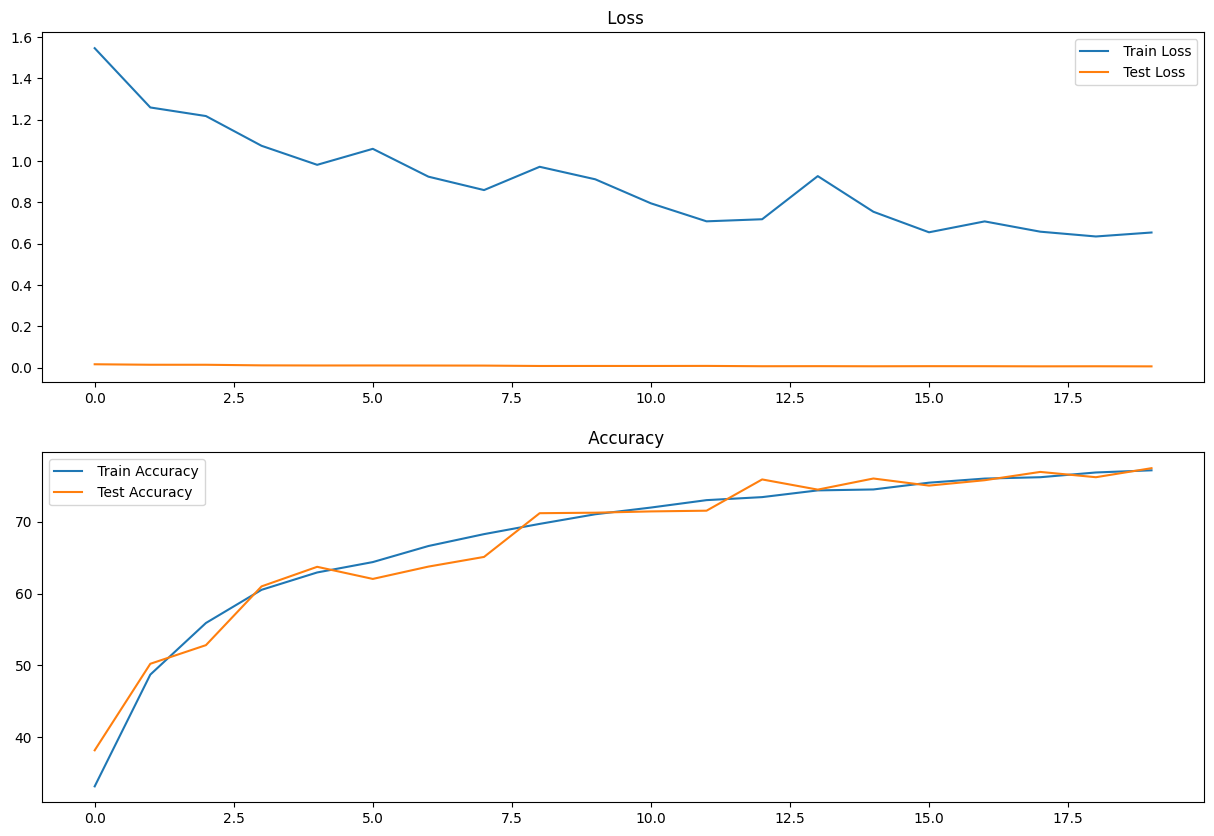

In [44]:
TTE.plotPerformanceGraph()

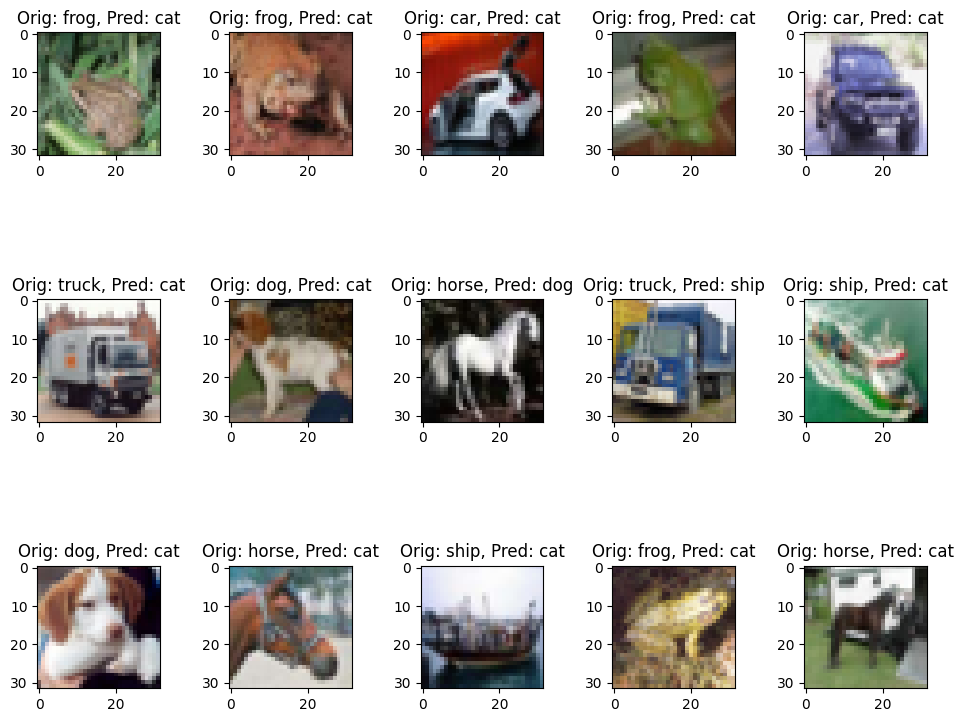

In [46]:
TTE.MissClassifedImage(testloader2,modelBN,device, 15,classes)

#Training with Group normalisation model

In [47]:
TTEGN=train_test_evaluate()
#Training(3,model)
TTEGN.Training(20,modelGN,device, trainloader, testloader,0.1 )

EPOCH: 0


Loss=1.6453633308410645 Batch_id=99 Accuracy=28.26: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s]



Test set: Average loss: 0.0172, Accuracy: 3739/10000 (37.39%)

EPOCH: 1


Loss=1.4065756797790527 Batch_id=99 Accuracy=40.74: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



Test set: Average loss: 0.0156, Accuracy: 4505/10000 (45.05%)

EPOCH: 2


Loss=1.3325591087341309 Batch_id=99 Accuracy=47.54: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



Test set: Average loss: 0.0142, Accuracy: 4910/10000 (49.10%)

EPOCH: 3


Loss=1.2048649787902832 Batch_id=99 Accuracy=52.51: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]



Test set: Average loss: 0.0124, Accuracy: 5500/10000 (55.00%)

EPOCH: 4


Loss=1.2288038730621338 Batch_id=99 Accuracy=56.26: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



Test set: Average loss: 0.0132, Accuracy: 5269/10000 (52.69%)

EPOCH: 5


Loss=1.0936181545257568 Batch_id=99 Accuracy=57.19: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



Test set: Average loss: 0.0114, Accuracy: 5934/10000 (59.34%)

EPOCH: 6


Loss=1.1464824676513672 Batch_id=99 Accuracy=60.77: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]



Test set: Average loss: 0.0107, Accuracy: 6258/10000 (62.58%)

EPOCH: 7


Loss=1.0236066579818726 Batch_id=99 Accuracy=62.76: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0111, Accuracy: 6176/10000 (61.76%)

EPOCH: 8


Loss=0.9932800531387329 Batch_id=99 Accuracy=64.29: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



Test set: Average loss: 0.0100, Accuracy: 6486/10000 (64.86%)

EPOCH: 9


Loss=0.9333816766738892 Batch_id=99 Accuracy=65.90: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]



Test set: Average loss: 0.0102, Accuracy: 6462/10000 (64.62%)

EPOCH: 10


Loss=0.9296727180480957 Batch_id=99 Accuracy=67.15: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



Test set: Average loss: 0.0089, Accuracy: 6851/10000 (68.51%)

EPOCH: 11


Loss=0.8793257474899292 Batch_id=99 Accuracy=68.67: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]



Test set: Average loss: 0.0089, Accuracy: 6893/10000 (68.93%)

EPOCH: 12


Loss=0.9397796392440796 Batch_id=99 Accuracy=69.01: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]



Test set: Average loss: 0.0087, Accuracy: 6963/10000 (69.63%)

EPOCH: 13


Loss=0.8638542294502258 Batch_id=99 Accuracy=69.12: 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]



Test set: Average loss: 0.0080, Accuracy: 7200/10000 (72.00%)

EPOCH: 14


Loss=0.7334489822387695 Batch_id=99 Accuracy=71.21: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]



Test set: Average loss: 0.0080, Accuracy: 7222/10000 (72.22%)

EPOCH: 15


Loss=0.8275790214538574 Batch_id=99 Accuracy=72.02: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s]



Test set: Average loss: 0.0079, Accuracy: 7206/10000 (72.06%)

EPOCH: 16


Loss=0.697054922580719 Batch_id=99 Accuracy=72.89: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]



Test set: Average loss: 0.0075, Accuracy: 7384/10000 (73.84%)

EPOCH: 17


Loss=0.7743778824806213 Batch_id=99 Accuracy=73.24: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0076, Accuracy: 7329/10000 (73.29%)

EPOCH: 18


Loss=0.7761121392250061 Batch_id=99 Accuracy=73.31: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



Test set: Average loss: 0.0075, Accuracy: 7377/10000 (73.77%)

EPOCH: 19


Loss=0.7871745824813843 Batch_id=99 Accuracy=74.09: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]



Test set: Average loss: 0.0073, Accuracy: 7420/10000 (74.20%)



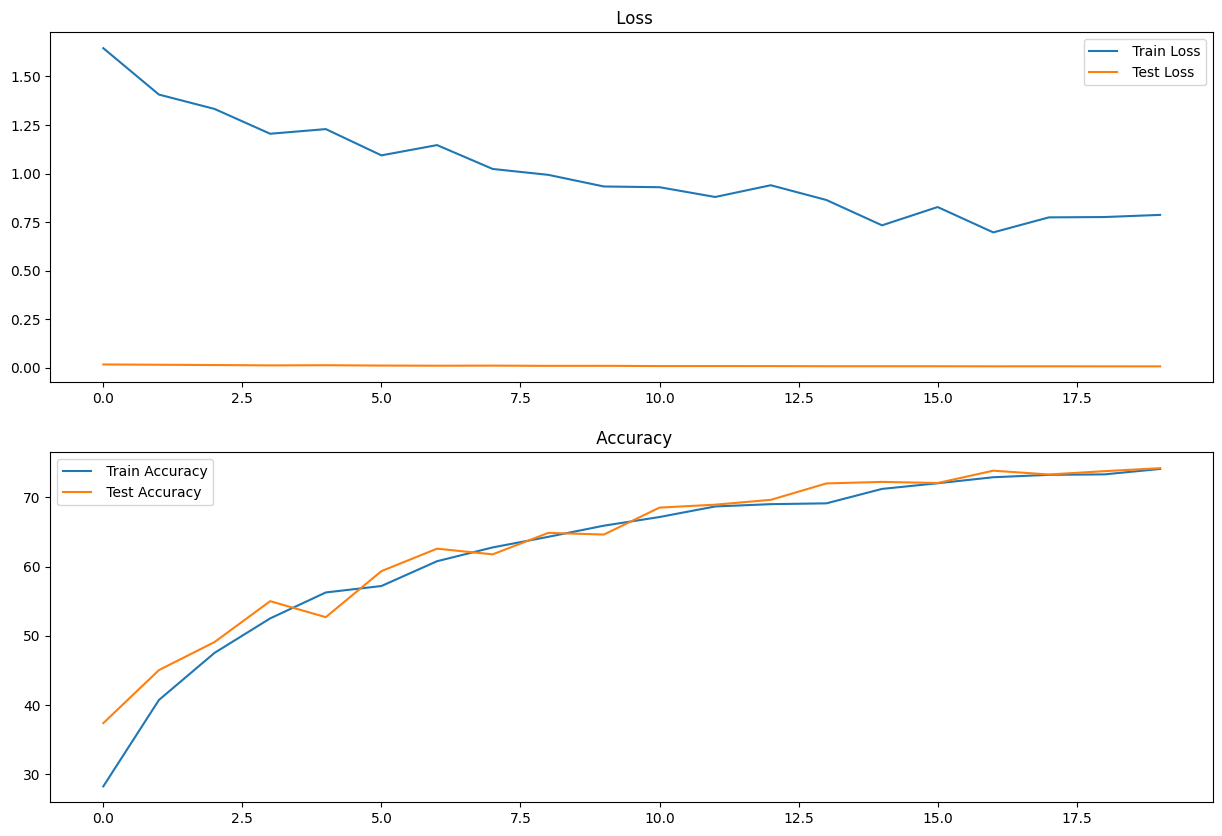

In [48]:
TTEGN.plotPerformanceGraph()

#Training with Layer normalisation

In [49]:
TTELN=train_test_evaluate()
#Training(3,model)
TTELN.Training(20,modelLN,device, trainloader, testloader,0.1 )

EPOCH: 0


Loss=1.7173994779586792 Batch_id=99 Accuracy=25.84: 100%|██████████| 100/100 [00:53<00:00,  1.89it/s]



Test set: Average loss: 0.0178, Accuracy: 3392/10000 (33.92%)

EPOCH: 1


Loss=1.6034427881240845 Batch_id=99 Accuracy=37.19: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0166, Accuracy: 4088/10000 (40.88%)

EPOCH: 2


Loss=1.442124605178833 Batch_id=99 Accuracy=44.11: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0148, Accuracy: 4741/10000 (47.41%)

EPOCH: 3


Loss=1.3852235078811646 Batch_id=99 Accuracy=49.25: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0142, Accuracy: 5005/10000 (50.05%)

EPOCH: 4


Loss=1.2089176177978516 Batch_id=99 Accuracy=53.25: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]



Test set: Average loss: 0.0130, Accuracy: 5394/10000 (53.94%)

EPOCH: 5


Loss=1.0586133003234863 Batch_id=99 Accuracy=56.61: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



Test set: Average loss: 0.0122, Accuracy: 5828/10000 (58.28%)

EPOCH: 6


Loss=1.1215416193008423 Batch_id=99 Accuracy=58.78: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]



Test set: Average loss: 0.0110, Accuracy: 6041/10000 (60.41%)

EPOCH: 7


Loss=1.0453577041625977 Batch_id=99 Accuracy=60.98: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]



Test set: Average loss: 0.0115, Accuracy: 6071/10000 (60.71%)

EPOCH: 8


Loss=0.9809242486953735 Batch_id=99 Accuracy=62.96: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]



Test set: Average loss: 0.0100, Accuracy: 6425/10000 (64.25%)

EPOCH: 9


Loss=0.9390400648117065 Batch_id=99 Accuracy=65.15: 100%|██████████| 100/100 [00:53<00:00,  1.87it/s]



Test set: Average loss: 0.0096, Accuracy: 6694/10000 (66.94%)

EPOCH: 10


Loss=1.0579476356506348 Batch_id=99 Accuracy=65.53: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]



Test set: Average loss: 0.0107, Accuracy: 6311/10000 (63.11%)

EPOCH: 11


Loss=0.9347577095031738 Batch_id=99 Accuracy=66.68: 100%|██████████| 100/100 [00:52<00:00,  1.89it/s]



Test set: Average loss: 0.0094, Accuracy: 6734/10000 (67.34%)

EPOCH: 12


Loss=0.9644299149513245 Batch_id=99 Accuracy=67.14: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]



Test set: Average loss: 0.0091, Accuracy: 6830/10000 (68.30%)

EPOCH: 13


Loss=0.9791962504386902 Batch_id=99 Accuracy=68.42: 100%|██████████| 100/100 [00:52<00:00,  1.91it/s]



Test set: Average loss: 0.0087, Accuracy: 6975/10000 (69.75%)

EPOCH: 14


Loss=0.8868600130081177 Batch_id=99 Accuracy=69.35: 100%|██████████| 100/100 [00:53<00:00,  1.86it/s]



Test set: Average loss: 0.0085, Accuracy: 7091/10000 (70.91%)

EPOCH: 15


Loss=0.7691745758056641 Batch_id=99 Accuracy=70.05: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]



Test set: Average loss: 0.0089, Accuracy: 6997/10000 (69.97%)

EPOCH: 16


Loss=0.7833318710327148 Batch_id=99 Accuracy=70.63: 100%|██████████| 100/100 [00:55<00:00,  1.80it/s]



Test set: Average loss: 0.0085, Accuracy: 7085/10000 (70.85%)

EPOCH: 17


Loss=0.7805978655815125 Batch_id=99 Accuracy=71.67: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]



Test set: Average loss: 0.0079, Accuracy: 7278/10000 (72.78%)

EPOCH: 18


Loss=0.8217757940292358 Batch_id=99 Accuracy=72.38: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]



Test set: Average loss: 0.0075, Accuracy: 7375/10000 (73.75%)

EPOCH: 19


Loss=0.7471946477890015 Batch_id=99 Accuracy=72.51: 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]



Test set: Average loss: 0.0079, Accuracy: 7258/10000 (72.58%)



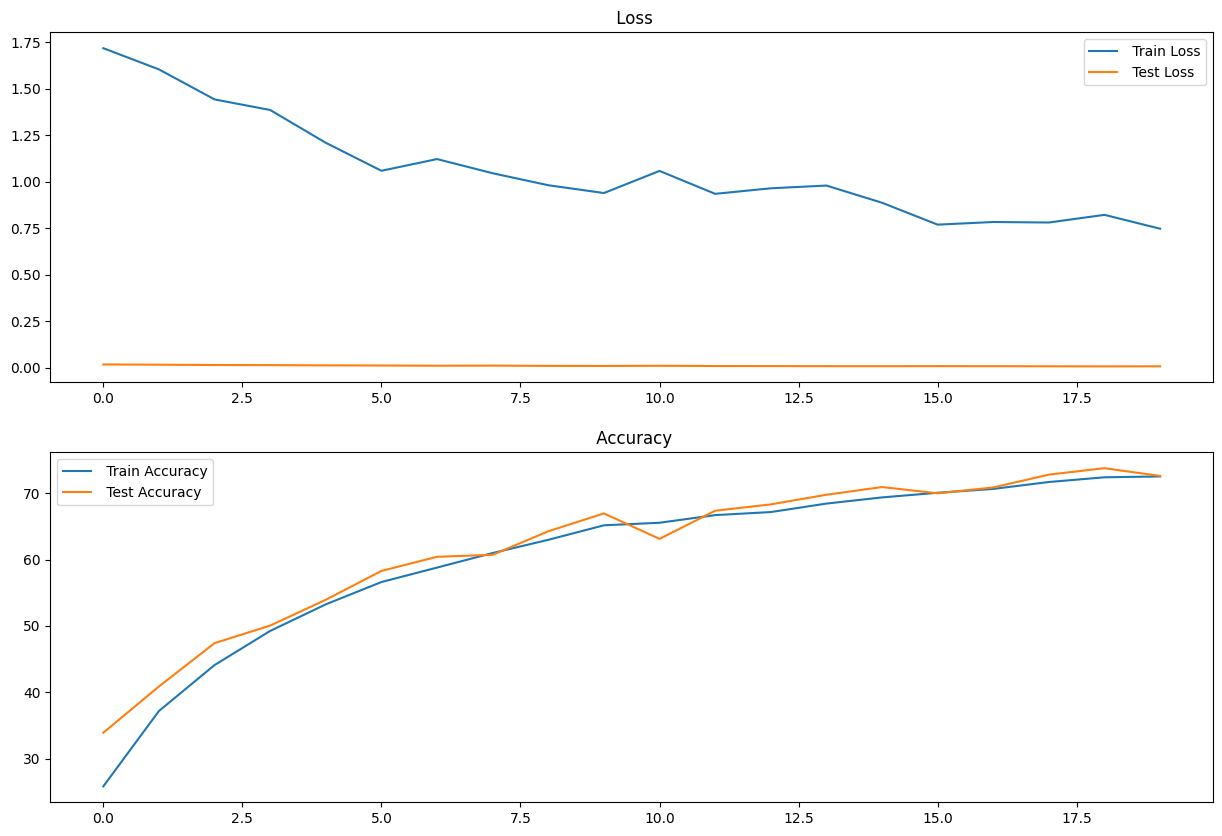

In [50]:
TTELN.plotPerformanceGraph()